# Name data: `common_Dstto3pi_BDT{cut_BDT}`

# Compute the sWeights 
For a given cut on the `BDT` value, with the starting value of the fit chosen as the result of the previous fit, specified by `cut_BDT_ref`, manually chosen to be `cut_BDT - 0.05`.
1. Fit on $m(3\pi)$ for $|m(3\pi) - 1968|<50$
    - Signal shape: Gaussian
    - Background shape: Exponential
2. Compute the associated probability and sWeights, save the sWeights in a Pickle file.
3. Plot some interesting things for checking
4. Save the full dataframe in a root file. It will be the input of `fit_all_data_V8_2_files_BDTs_recomputed_sWeights.ipynb`.

Thanks to the fit, we get
- $f_g(m)$, the signal Ds PDF
- $f_e(m)$, the background Ds PDF
Besides, our dataset is given by a list of events, each event is characterised by $m_{3\pi})$

We define the probability of the event $e$ being a $D_s$ by:
$$P\left(e = D_s\right)=\frac{f_g(m_{e, 3\pi})}{\sum_{event\ k}{\left(f_g(m_{k,3\pi})+f_e(m_{k, 3\pi})\right)}}$$

From this probabily, the sWeights can be computed.

The saved root file is already cut on the `BDT` output, and has a new column `sWeight`. The root files are saved in `output/root/common/`

In [1]:
import zfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hep_ml import splot
import timeit
from scipy.stats import pearsonr

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_saved_root, save_dataframe, add_constr_Dst, json_to_latex_table, retrieve_params, format_previous_params
from plot.tool import fix_plot
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import launch_fit, define_zparams, save_params
from variables import name_params_tau

/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Welcome to JupyROOT 6.22/02


In [2]:
name_data = 'common_Dstto3pi'
name_BDT = 'gradient_bkgHighB0M'

## INIT

### Retrieve data

In [3]:
# load_data does the cut on DeltaM and tau_M (around m(Ds)).
df_common_Ds = load_saved_root('common_'+name_BDT, name_folder='common', vars=['B0_M', 'tau_M', 'Dst_M', 'BDT'])
df_common_Ds = add_constr_Dst(df_common_Ds)

/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_gradient_bkgHighB0M.root


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.2)'>)

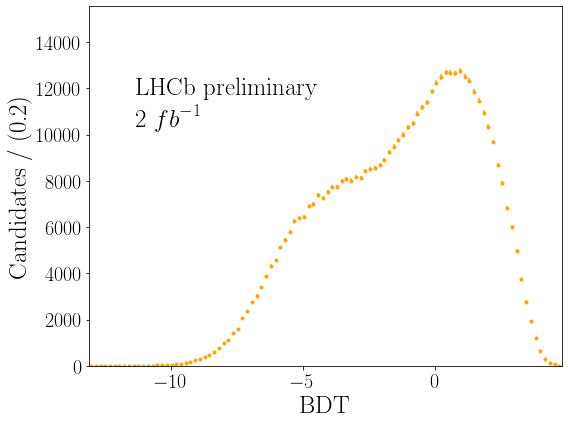

In [8]:
h.plot_hist_particle({'data': df_common_Ds},'BDT',
              n_bins = 100, mode_hist = False, colors=['orange', 'cyan'], pos_text_LHC=[0.1,0.8,'left'])

### BDT cuts

Reference fit whose results are taken as the starting values of the new fit.
It is specified by `cut_BDT_ref`, the cut on the `BDT` output.
If None, the reference fit is the one performed without any cut on the `BDT` output.

In [16]:
def round_int(n):
    if n%1==0:
        return int(n)
    else:
        return n

l_BDT = []
l_BDT_ref = []
#starting_value = -0.4
starting_value = -6.
end_value      =  1.75
step           = 0.25


value = starting_value
while value <= end_value:
    if value==0:
        value = 0
    
    if value%0.5!=0:
        l_BDT.append(round_int(value))

        if value <= -9.5:
            l_BDT_ref.append(None)
        else:
            BDT_ref = np.round(l_BDT[-1]-step,4)
            BDT_ref = round_int(BDT_ref)
            l_BDT_ref.append(BDT_ref)
    
    value = np.round(value + step, 3)

# l_BDT = [0.35]
# l_BDT_ref = [0.3]

In [17]:
l_BDT_ref

[-6, -5.5, -5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5]

### Range of the variable

In [18]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M
df_Ds = df_common_Ds.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

## LOOP

In [ ]:
for cut_BDT, cut_BDT_ref in zip(l_BDT, l_BDT_ref):
    ## CUT ON BDT -------------------------------------------------------
    k = str(cut_BDT)
    df_Ds = df_Ds.query(f"BDT > {cut_BDT}")
    
    print(f"================================ cut_BDT = {k} ================================")
    print(f"cut_BDT_ref = {cut_BDT_ref}")
    
    ## REFERENCE BDT CUT ------------------------------------------------
    if cut_BDT_ref is None:
        params_r = retrieve_params(name_data, name_folder=name_data)
    else:
        name_data_BDT_ref = f"{name_data}_BDT{cut_BDT_ref}"
        params_r = retrieve_params(name_data_BDT_ref, name_folder=name_data)
        params_r = format_previous_params(params_r)
    
    ### HISTOGRAM --------------------------------------------------------
    h.plot_hist_particle({name_data:df_Ds},'tau_M', cut_BDT=cut_BDT,
              n_bins = 100, mode_hist = False, colors='black')
    
    ### FITTING ----------------------------------------------------------
    ## Starting point ........................
    n_events_tau_M = len(df_Ds)
    initial_values_tau = {
        'mu_tau': {
            'value' : params_r['mu_tau'],
            'low': 1965.,
            'high': 1975.,     
        },
        'sigma_tau': {
            'value' : params_r['sigma_tau'],
            'low': 5.,
            'high': 15.,
        },
        'n_bkg_tau': {
            'value' : params_r['n_bkg_tau'],
            'low': 0,
            'high': n_events_tau_M,  
        },
        'n_sig_tau': {
            'value' : params_r['n_sig_tau'],
            'low': 0,
            'high': n_events_tau_M,  
        },
        'lambda_tau': {
            'value' : params_r['lambda_tau'],
            'low': -0.01,
            'high': -0.000001  
        }
    }
    
    ## Parameters .............................
    obs_tau = zfit.Space("x", limits=(low_tau_M, high_tau_M))
    zparams_tau = define_zparams(initial_values_tau, cut_BDT=cut_BDT)

    ## Name of the variables ..................
    name_params_tau_BDT = {
        # Signal
        f'mu_tau|BDT{cut_BDT}'     :'$\mu_{S}$',
        f'sigma_tau|BDT{cut_BDT}'  :'$\sigma_{S}$',
        f'n_sig_tau|BDT{cut_BDT}'  :'$n_{S}$',
        # Combinatorial background
        f'n_bkg_tau|BDT{cut_BDT}'  :'$n_{B,c}$',
        f'lambda_tau|BDT{cut_BDT}' :'$\\lambda_{B,c}$',
    }
    
    ## PDFs ...................................
    gaussian_tau = zfit.pdf.Gauss(zparams_tau["mu_tau"],zparams_tau["sigma_tau"],obs=obs_tau)
    exponential_tau = zfit.pdf.Exponential(zparams_tau["lambda_tau"], obs=obs_tau)

    gaussian_ext_tau = gaussian_tau.create_extended(zparams_tau["n_sig_tau"])
    exp_ext_tau = exponential_tau.create_extended(zparams_tau["n_bkg_tau"])
    model_tau = zfit.pdf.SumPDF([gaussian_ext_tau, exp_ext_tau]) # gauss is folded by frac

    data_tau = zfit.Data.from_pandas(df_Ds['tau_M'],obs=obs_tau)
    
    ## Launch the fit .........................
    start = timeit.default_timer()
    result_tau, params_tau = launch_fit(model_tau, data_tau, extended=True)
    result_tau, params_tau = launch_fit(model_tau, data_tau, extended=True)
    stop = timeit.default_timer()
    print('Time to do the fit: ', stop - start) 
    
    ## Result of the fit ......................
    plot_hist_fit_particle(df_Ds,'tau_M', models = [model_tau,gaussian_ext_tau,exp_ext_tau], 
                           name_models = ["", '$D_S \\to 3\pi$',''], colors = ['b','r','y'],
                           obs=obs_tau, n_bins = 100,mode_hist = False, name_data=name_data+'_detail', 
                          params=params_tau,name_params=name_params_tau_BDT, fontsize_leg=15.,
                          cut_BDT=cut_BDT)
    plot_hist_fit_particle(df_Ds,'tau_M', models = [model_tau,gaussian_ext_tau,exp_ext_tau], 
                           name_models = ["", '$D_S \\to 3\pi$',''], colors = ['b','r','y'],
                           obs=obs_tau, n_bins = 100,mode_hist = False, name_data=name_data, 
                           fontsize_leg=16., pos_text_LHC='right',
                          cut_BDT=cut_BDT)
    ## Correlation ...........................
    corr_B0_M_tau_M = pearsonr(df_Ds['tau_M'], df_Ds['B0_M'])[0]
    print(corr_B0_M_tau_M)
    
    ## Save the result .......................
    name_data_BDT = name_data + f'_BDT{cut_BDT}'
    save_params(params_tau, name_data_BDT, True, {'corr_B0_M_tau_M': corr_B0_M_tau_M}, name_folder=name_data)
    json_to_latex_table(name_data_BDT, name_data, name_params_tau)
    ### SWEIGHTS -------------------------------------------------------------------
    ## Computation ...........................
    
    # Probability that the candidate is actually a Ds particle.
    mass = df_Ds['tau_M']
    probs = pd.DataFrame(dict(sig=gaussian_ext_tau.pdf(mass), bkg=exp_ext_tau.pdf(mass)))
    probs = probs.div(probs.sum(axis=1), axis=0) # normalisation
    # sWeights
    sWeights = splot.compute_sweights(probs)
    
    ## Analysis of the sWeights .............
    fig, ax = plt.subplots(figsize=(8,6))

    ax.plot(mass, probs.sig,'.', label='Signal')
    ax.plot(mass, probs.bkg,'.', label='Background')

    plt.xlim(low_tau_M, high_tau_M) 
    plt.xlabel('$m(3\pi)$',fontsize=20)
    plt.ylabel('Probability',fontsize=20)
    
    plt.show()
    plt.close()
    
    fig, ax = plt.subplots(figsize=(8,6))

    ax.plot(mass, sWeights.sig,'.', label='Signal')
    ax.plot(mass, sWeights.bkg,'.', label='Background')

    plt.xlim(low_tau_M, high_tau_M) 
    fix_plot(ax, ymax=None)

    plt.xlabel('$m(3\pi)$',fontsize=20)
    plt.ylabel('sWeights',fontsize=20)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax*1.1)

    plt.show()
    plt.close()
    
    ### Save the result ----------------------------------------------------------------
    save_dataframe(sWeights, name_data_BDT+'_sWeights', 'sWeights', name_folder=name_data)
    df_Ds['sWeight'] = sWeights.sig.to_numpy()
    save_dataframe(df_Ds, name_data_BDT, 'DecayTree', name_folder=name_data)